<a href="https://colab.research.google.com/github/Shiva8164/Plagiarism_Checker_ai/blob/main/plagiarism_checker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = "/content/drive/MyDrive/train_snli.txt"
with open(file_path, "r") as file:
    content = file.read()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
df = pd.read_csv(file_path, delimiter="\t", header=None, names=["Original_text", "Plagiarism_text", "Label"])

In [5]:
df.isnull().sum()

,0
Original_text,0
Plagiarism_text,4
Label,0


In [6]:
df.dropna(inplace=True)

In [7]:
df['Label'].value_counts()

,count
Label,
0,183964
1,183405


<ipython-input-8-075323fd5ebf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=["#2E4053", "#A93226"])


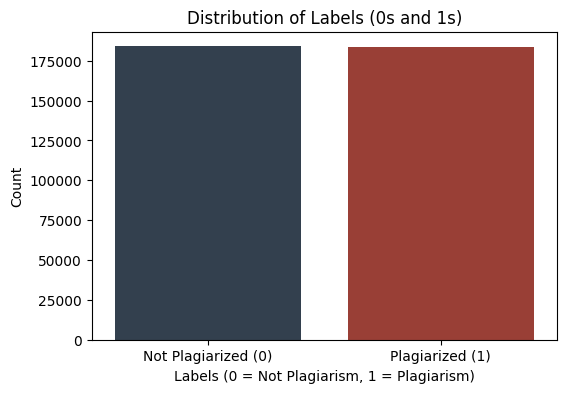

In [8]:
label_counts = df["Label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=["#2E4053", "#A93226"])

plt.xlabel("Labels (0 = Not Plagiarism, 1 = Plagiarism)")
plt.ylabel("Count")
plt.title("Distribution of Labels (0s and 1s)")
plt.xticks([0, 1], labels=["Not Plagiarized (0)", "Plagiarized (1)"])
plt.show()

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
def cleaning_data(data):
  data = data.lower()
  data = re.sub(r'[^\w\s]', '', data)
  stopword = set(stopwords.words('english'))
  data = ' '.join([x for x in data.split() if x not in stopword])
  lemmatizer = WordNetLemmatizer()
  data = ' '.join([lemmatizer.lemmatize(x) for x in data.split()])
  return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
df["Original_text"] = df["Original_text"].apply(cleaning_data)
df["Plagiarism_text"] = df["Plagiarism_text"].apply(cleaning_data)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X1 = tfidf_vectorizer.fit_transform(df["Original_text"])
X2 = tfidf_vectorizer.transform(df["Plagiarism_text"])
X = np.abs(X1+X2)
y = df["Label"].values

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X = pca.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
LR_pred = LR.predict(X_test)
LR_accuracy = accuracy_score(y_test, LR_pred)
print("Accuracy: ", LR_accuracy)
print(classification_report(y_test, LR_pred))

Accuracy:  0.6215532024933991
              precision    recall  f1-score   support

           0       0.61      0.68      0.64     36586
           1       0.64      0.57      0.60     36888

    accuracy                           0.62     73474
   macro avg       0.62      0.62      0.62     73474
weighted avg       0.62      0.62      0.62     73474



In [15]:
!pip install lightgbm

In [16]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

lgbm_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

In [17]:
y_pred = lgbm_model.predict(X_test)
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6938

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69     36586
           1       0.70      0.69      0.69     36888

    accuracy                           0.69     73474
   macro avg       0.69      0.69      0.69     73474
weighted avg       0.69      0.69      0.69     73474

